<a href="https://colab.research.google.com/github/chaulagai2001/Speech_for_timit_dataset/blob/main/model_definition_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Move the uploaded Kaggle API key to the required directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Replace "your_dataset" with the Kaggle dataset username/dataset name
!kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech

 99% 818M/829M [00:08<00:00, 122MB/s]
100% 829M/829M [00:08<00:00, 97.0MB/s]


In [4]:
!unzip -q darpa-timit-acousticphonetic-continuous-speech.zip -d darpa-timit-acousticphonetic-continuous-speech

In [5]:
import os
import librosa

def get_longest_length(root_dir):
    max_length = 0
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.wav'):  # adjust extension if needed
                file_path = os.path.join(subdir, file)
                audio, _ = librosa.load(file_path, sr=None)
                max_length = max(max_length, len(audio))
    return max_length

root_directory = '/content/darpa-timit-acousticphonetic-continuous-speech/data'
longest_length = get_longest_length(root_directory)
print("Longest length:", longest_length)


Longest length: 124621


In [6]:
import os
import numpy as np
import torch
import librosa

# Phoneme mapping dictionary
phn_map = {
    "iy": 1, "ix": 2, "ih": 3, "eh": 4, "ae": 5, "ax": 6, "ah": 7, "ax-h": 8, "uw": 9, "ux": 10,
    "uh": 11, "ao": 12, "aa": 13, "ey": 14, "ay": 15, "oy": 16, "aw": 17, "ow": 18, "er": 19,
    "axr": 20, "l": 21, "el": 22, "r": 23, "w": 24, "y": 25, "m": 26, "em": 27, "n": 28, "en": 29,
    "nx": 30, "ng": 31, "eng": 32, "v": 33, "f": 34, "dh": 35, "th": 36, "z": 37, "s": 38, "zh": 39,
    "sh": 40, "jh": 41, "ch": 42, "b": 43, "p": 44, "d": 45, "dx": 46, "t": 47, "g": 48, "k": 49,
    "hh": 50, "hv": 51, "bcl": 52, "pcl": 53, "dcl": 54, "tcl": 55, "gcl": 56, "kcl": 57, "q": 58,
    "epi": 59, "pau": 60, "h#": 61, "tcl": 62, "ix": 63, "ax": 64
}

class TIMITSample:
    def __init__(self, wav_file, phn_file, sample_rate=16000, audio_length=16000):
        self.wav_file = wav_file
        self.phn_file = phn_file
        self.sample_rate = sample_rate
        self.audio_length = audio_length

        self.process_sample()

    def process_sample(self):
        # Load and preprocess audio
        waveform, _ = librosa.load(self.wav_file, sr=self.sample_rate, mono=True, duration=self.audio_length/self.sample_rate)
        # Perform padding or truncation
        if len(waveform) < self.audio_length:
            pad_amount = self.audio_length - len(waveform)
            waveform = np.pad(waveform, (0, pad_amount), mode='constant')
        else:
            waveform = waveform[:self.audio_length]
        # Normalize waveform
        self.waveform = waveform.astype(np.float32) / np.max(np.abs(waveform))

        # Process labels using provided phoneme mapping dictionary
        with open(self.phn_file, 'r') as f:
            lines = f.readlines()
            labels = []
            for line in lines:
                _, _, label = line.strip().split(' ')
                labels.append(phn_map[label.lower()])  # Map label to numeric value using lowercase label
            self.labels = torch.tensor(labels)

    def extract_mfcc(self, n_mfcc=13, win_len=0.025, win_step=0.01):
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=self.waveform, sr=self.sample_rate, n_mfcc=n_mfcc, hop_length=int(self.sample_rate*win_step), n_fft=int(self.sample_rate*win_len))

        # Compute delta and delta-delta features
        delta_mfcc = librosa.feature.delta(mfcc, order=1)
        delta_delta_mfcc = librosa.feature.delta(mfcc, order=2)

        # Concatenate MFCC with delta, delta-delta, and delta-delta-delta
        feat = np.concatenate((mfcc, delta_mfcc, delta_delta_mfcc), axis=0)

        # Transpose feature matrix to have frames as rows
        feat = np.transpose(feat)

        return feat, self.labels

# Provide the path to a single .wav file and its corresponding .phn file
wav_file_path = '/content/darpa-timit-acousticphonetic-continuous-speech/data/TEST/DR1/FAKS0/SA1.WAV.wav'
phn_file_path = '/content/darpa-timit-acousticphonetic-continuous-speech/data/TEST/DR1/FAKS0/SA1.PHN'

# Initialize a TIMITSample instance
sample = TIMITSample(wav_file_path, phn_file_path)

# Extract MFCC features and corresponding labels
mfcc_features, labels = sample.extract_mfcc()

# Print shapes and labels
print("MFCC features shape:", mfcc_features.shape)
print(f"MFCC features: {mfcc_features}")
print("Labels:", labels)


MFCC features shape: (101, 39)
MFCC features: [[-6.8276794e+02  1.1592339e+01  1.1371281e+01 ... -1.9903464e-02
  -8.0245900e-01 -9.9338686e-01]
 [-6.8503485e+02  7.5996628e+00  7.2753029e+00 ... -1.9903464e-02
  -8.0245900e-01 -9.9338686e-01]
 [-6.8394299e+02  8.9573126e+00  8.8233643e+00 ... -1.9903464e-02
  -8.0245900e-01 -9.9338686e-01]
 ...
 [-2.5071683e+02  5.0535942e+01 -7.8345879e+01 ...  3.1451304e+00
  -2.9934117e-01  1.1730026e-01]
 [-2.4914731e+02  5.3415001e+01 -6.3599903e+01 ...  3.1451304e+00
  -2.9934117e-01  1.1730026e-01]
 [-1.8479712e+02  7.8521271e+01 -5.2789696e+01 ...  3.1451304e+00
  -2.9934117e-01  1.1730026e-01]]
Labels: tensor([61, 40,  1, 51,  5, 54, 45, 25, 19, 54, 45, 13, 23, 57, 49, 38,  9, 46,
         3, 31, 56, 48, 23,  1, 38,  1, 24, 13, 40, 59, 24, 13, 46, 19, 58, 12,
        21, 25,  1, 20, 61])


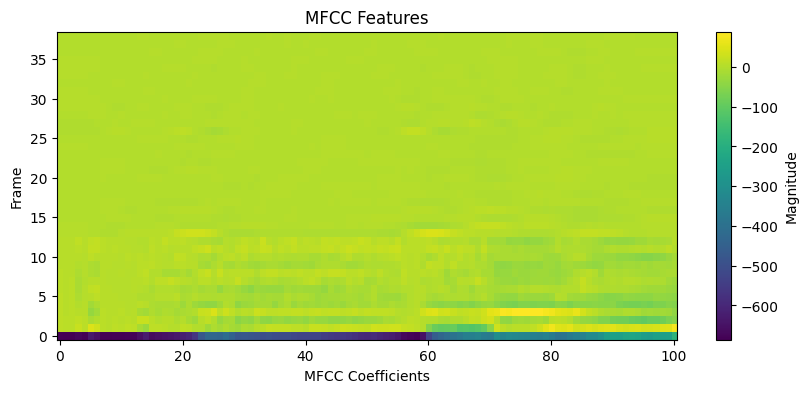

In [7]:
import matplotlib.pyplot as plt

# Initialize a TIMITSample instance
sample = TIMITSample(wav_file_path, phn_file_path)

# Extract MFCC features and corresponding labels
mfcc_features, labels = sample.extract_mfcc()

# Plot MFCC features
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_features.T, origin='lower', aspect='auto', cmap='viridis')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Frame')
plt.title('MFCC Features')
plt.colorbar().set_label('Magnitude')
plt.show()


In [8]:
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import os

class TIMITDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.file_pairs = self._get_file_pairs()

    def _get_file_pairs(self):
        file_pairs = []
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith(".WAV.wav"):
                    wav_file_path = os.path.join(root, file)
                    phn_file_path = os.path.join(root, file.replace(".WAV.wav", ".PHN"))
                    if os.path.exists(phn_file_path):
                        file_pairs.append((wav_file_path, phn_file_path))
        return file_pairs

    def __len__(self):
        return len(self.file_pairs)

    def __getitem__(self, idx):
        wav_file, phn_file = self.file_pairs[idx]
        sample = TIMITSample(wav_file, phn_file)
        mfcc_features, labels = sample.extract_mfcc()

        # Convert MFCC features to torch tensors
        mfcc_tensors = [torch.tensor(x) for x in mfcc_features]

        # Pad sequences to ensure they all have the same length
        padded_mfcc = pad_sequence(mfcc_tensors, batch_first=True)

        return padded_mfcc, labels


In [10]:
# Directory containing .wav and .phn files
data_dir = '/content/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN'

# Instantiate TIMITDataset
train = TIMITDataset(data_dir)

# Preprocess and store data
processed_data_dir = '/content/train_npy'

for idx, (mfcc_features, labels) in enumerate(train):
    # Create directories if they don't exist
    os.makedirs(processed_data_dir, exist_ok=True)

    # Save MFCC features and labels to NumPy files
    np.save(os.path.join(processed_data_dir, f'mfcc_{idx}.npy'), mfcc_features.numpy())
    np.save(os.path.join(processed_data_dir, f'labels_{idx}.npy'), labels.numpy())


In [11]:
# preprocess and store for test data
data_dir = '/content/darpa-timit-acousticphonetic-continuous-speech/data/TEST'

# Instantiate TIMITDataset
test = TIMITDataset(data_dir)

# Preprocess and store data
processed_data_dir = '/content/test_npy'

for idx, (mfcc_features, labels) in enumerate(test):
    # Create directories if they don't exist
    os.makedirs(processed_data_dir, exist_ok=True)

    # Save MFCC features and labels to NumPy files
    np.save(os.path.join(processed_data_dir, f'mfcc_{idx}.npy'), mfcc_features.numpy())
    np.save(os.path.join(processed_data_dir, f'labels_{idx}.npy'), labels.numpy())

In [12]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming you have already defined TIMITDataset class and processed the test data as in your previous code

# Preprocess and store data
processed_data_dir = '/content/test_npy'
os.makedirs(processed_data_dir, exist_ok=True)

# Collect all the processed data paths
mfcc_paths = sorted([os.path.join(processed_data_dir, f) for f in os.listdir(processed_data_dir) if f.startswith('mfcc_')])
label_paths = sorted([os.path.join(processed_data_dir, f) for f in os.listdir(processed_data_dir) if f.startswith('labels_')])

# Load all the processed data
mfcc_data = [np.load(path) for path in mfcc_paths]
label_data = [np.load(path) for path in label_paths]

# Split the data into test and validation sets
test_mfcc, val_mfcc, test_labels, val_labels = train_test_split(mfcc_data, label_data, test_size=0.2, random_state=42)

# Save the split data into separate directories for test and validation
test_data_dir = os.path.join(processed_data_dir, 'test')
val_data_dir = os.path.join(processed_data_dir, 'validation')

os.makedirs(test_data_dir, exist_ok=True)
os.makedirs(val_data_dir, exist_ok=True)

# Save test data
for idx, (mfcc, labels) in enumerate(zip(test_mfcc, test_labels)):
    np.save(os.path.join(test_data_dir, f'mfcc_{idx}.npy'), mfcc)
    np.save(os.path.join(test_data_dir, f'labels_{idx}.npy'), labels)

# Save validation data
for idx, (mfcc, labels) in enumerate(zip(val_mfcc, val_labels)):
    np.save(os.path.join(val_data_dir, f'mfcc_{idx}.npy'), mfcc)
    np.save(os.path.join(val_data_dir, f'labels_{idx}.npy'), labels)


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MfccDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mfcc_files = sorted([f for f in os.listdir(root_dir) if f.startswith('mfcc_')])
        self.label_files = sorted([f for f in os.listdir(root_dir) if f.startswith('labels_')])
        self.max_length = self.get_max_length()

    def __len__(self):
        return len(self.mfcc_files)

    def __getitem__(self, idx):
        mfcc_path = os.path.join(self.root_dir, self.mfcc_files[idx])
        label_path = os.path.join(self.root_dir, self.label_files[idx])

        mfcc = np.load(mfcc_path)  # Assuming MFCC files are numpy arrays
        label = np.load(label_path)  # Assuming label files are numpy arrays

        # Pad MFCCs and labels to the max length
        mfcc = self.pad_sequence(mfcc, self.max_length)
        label = self.pad_sequence(label, self.max_length)

        if self.transform:
            mfcc = self.transform(mfcc)

        return mfcc, label

    def get_max_length(self):
        max_length = 0
        for mfcc_file in self.mfcc_files:
            mfcc_path = os.path.join(self.root_dir, mfcc_file)
            mfcc = np.load(mfcc_path)
            max_length = max(max_length, mfcc.shape[0])
        return max_length

    def pad_sequence(self, sequence, max_length):
        current_length = sequence.shape[0]
        if current_length < max_length:
            # Pad with zeros
            padding = np.zeros((max_length - current_length, *sequence.shape[1:]), dtype=sequence.dtype)
            sequence = np.concatenate((sequence, padding), axis=0)
        return sequence

def create_data_loader(dataset, batch_size, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def main():
    # Example root directories containing MFCC and label files
    train_root_dir = '/content/train_npy'
    val_root_dir = '/content/test_npy/validation'
    test_root_dir = '/content/test_npy/test'

    # Create datasets
    train_dataset = MfccDataset(train_root_dir)
    val_dataset = MfccDataset(val_root_dir)
    test_dataset = MfccDataset(test_root_dir)

    # Create DataLoader for each dataset
    batch_size = 32
    train_loader = create_data_loader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = create_data_loader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(test_dataset, batch_size=batch_size, shuffle=False)


    # Example of iterating through the DataLoader
    for batch_idx, (mfcc_batch, label_batch) in enumerate(train_loader):
        print("for train dataset")
        print(f"Batch {batch_idx + 1}:")
        print("MFCC Shape:", mfcc_batch.shape)
        print("Label Shape:", label_batch.shape)

    return train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader

if __name__ == "__main__":
    main()


In [34]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 26, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 26)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# Import your MfccDataset class

# Hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 32

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, optimizer, criterion):
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (mfcc, labels) in enumerate(train_loader):
            mfcc, labels = mfcc.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(mfcc)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_idx % 100 == 0:
                print('Epoch {}, Batch {}, Train Loss: {:.3f}, Accuracy: {:.3f}'.format(
                    epoch, batch_idx + 1, train_loss / (batch_idx + 1), correct / total))

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for mfcc, labels in val_loader:
                mfcc, labels = mfcc.to(device), labels.to(device)
                outputs = model(mfcc)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        print('Epoch {}, Validation Loss: {:.3f}, Accuracy: {:.3f}'.format(
            epoch, val_loss / len(val_loader), val_acc))

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pt')

    print('Best Validation Accuracy: {:.3f}'.format(best_val_acc))

# Create model and set to device
model = CNNModel(num_features=39, num_classes=10)  # Adjust feature and class count
model.to(device)

# Define criterion and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

train_dataset = MfccDataset("/content/train_npy")
val_dataset = MfccDataset("/content/test_npy/validation")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train the model
train_model(model, train_loader, val_loader, optimizer, criterion)

print('Finished training!')


RuntimeError: Given groups=1, weight of size [32, 39, 3], expected input[32, 101, 39] to have 39 channels, but got 101 channels instead